The provided project for running an experiment with the BioBART-v2-large model for summarization tasks. It includes installation of required libraries, downloading a dataset, preprocessing, creating data loaders, loading the model, and setting up the training parameters.

Here's a breakdown of what each part does:

* Installation of Dependencies: The script starts with the installation of necessary Python packages like torch, bitsandbytes, trl (Transformers Reinforcement Learning), transformers, peft (Parameter Efficient Fine-tuning), accelerate, datasets, and sentencepiece.

* Restart the Environment: To ensure that all installed packages are properly loaded, the script restarts the runtime environment.

* Importing Libraries: It imports required libraries such as pandas, transformers, torch, gdown, zipfile, and os.

* Summarization Model Information: A brief description of the BioBART-v2-large model is provided, highlighting its design for biomedical tasks and its robust performance on various summarization benchmarks.

* Dataset Loading and Preprocessing: The script includes functions to download and extract a dataset from Google Drive, then reads the data into a pandas DataFrame. It preprocesses the data by cleaning it using a custom function that removes newline characters and repeated special characters.

* Dataset Preparation: It then creates the training and validation datasets by formatting the dialogue and summary into a suitable format for the model.

* Tokenization and Encoding: The script tokenizes and encodes the training and validation datasets using the tokenizer from the pre-trained BioBART-v2-large model.

* Setting Training Parameters: It defines a batch size and a learning rate for the training process.

* Data Loaders Creation: It creates data loaders for both training and validation datasets with the specified batch size.

* Model Loading: The BioBART-v2-large model is loaded with specific configuration settings that enable 4-bit quantization for efficiency. It then enables gradient checkpointing to reduce memory usage during training and prepares the model for k-bit training.

* Model Architecture Overview: It prints out the model's architecture, which could help in identifying which modules to target for optimization or further fine-tuning.

This script is an end-to-end pipeline for running summarization tasks on a specific dataset using the BioBART-v2-large model. It is likely intended for use in a research or experimentation context where summarization performance on biomedical text is being evaluated.


# Install the required dependencies.

In [1]:
!pip install torch
!pip install -q -U bitsandbytes trl
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets sentencepiece scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

**Restart the environment**

In [2]:
exit()

----

# Import necessary libraries

In [1]:
import pandas as pd
import transformers
import torch
import gdown
import zipfile
import os

# Summarization model
BioBART-v2-large, Developed as an extension of BioBART, this specialized variant is designed specifically for biomedical tasks. With its robust transformer-based architecture and incorporation of techniques such as pre-training and fine-tuning, BioBART-v2-large excels at generating exceptional abstractive summaries from input text. Having undergone training on an extensive and diverse dataset, it has achieved remarkable performance in various summarization benchmarks and competitions. As a result, BioBART-v2-large has gained widespread recognition within the natural language processing (NLP) community for its remarkable ability to produce coherent and concise summaries

## Load the dataset

### Get the data from the drive

In [2]:

def download_zip_from_drive(drive_link, output_path):
    """Download a zip file from a Google Drive link using gdown."""
    gdown.download(drive_link, output_path, quiet=False)
    print("Zip file downloaded successfully.")

def unzip_file(zip_path, extract_dir):
    """Extract the contents of a zip file into a given directory."""
    # Create the directory if it doesn't exist
    os.makedirs(extract_dir, exist_ok=True)

    # Extract the contents of the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Zip file extracted successfully.")


In [3]:
# https://drive.google.com/file/d/1zMj26O5ElYlzJUn5ooajf6eG7AOhuOu2/view?usp=sharing
drive_link = "https://drive.google.com/uc?id=1zMj26O5ElYlzJUn5ooajf6eG7AOhuOu2"
zip_output_path = "/content/MTS-Dialog-main.zip"
DATASET_BASE_DIR = "/content/"

In [4]:
download_zip_from_drive(drive_link, zip_output_path)

Downloading...
From: https://drive.google.com/uc?id=1zMj26O5ElYlzJUn5ooajf6eG7AOhuOu2
To: /content/MTS-Dialog-main.zip
100%|██████████| 2.61M/2.61M [00:00<00:00, 222MB/s]

Zip file downloaded successfully.


In [5]:
# Extract the files
unzip_file(zip_output_path, DATASET_BASE_DIR)

Zip file extracted successfully.


In [6]:
## load the train data
df  = pd.read_csv(os.path.join(DATASET_BASE_DIR,"MTS-Dialog-main","Main-Dataset","MTS-Dialog-TrainingSet.csv")).set_index("ID")
# load the validation data
df_test1  = pd.read_csv(os.path.join(DATASET_BASE_DIR,"MTS-Dialog-main","Main-Dataset","MTS-Dialog-TestSet-1-MEDIQA-Chat-2023.csv")).set_index("ID")
# drop nans
df_test1 = df_test1.dropna()
df = df.dropna()

df.head()

,section_header,section_text,dialogue
ID,,,
0,GENHX,The patient is a 76-year-old white female who ...,Doctor: What brings you back into the clinic t...
1,GENHX,The patient is a 25-year-old right-handed Cauc...,Doctor: How're you feeling today? \r\nPatient...
2,GENHX,"This is a 22-year-old female, who presented to...","Doctor: Hello, miss. What is the reason for yo..."
3,MEDICATIONS,Prescribed medications were Salmeterol inhaler...,Doctor: Are you taking any over the counter me...
4,CC,"Burn, right arm.","Doctor: Hi, how are you? \r\nPatient: I burned..."


In [7]:
df.iloc[0]

section_header                                                GENHX
section_text      The patient is a 76-year-old white female who ...
dialogue          Doctor: What brings you back into the clinic t...
Name: 0, dtype: object

## Clean and create the dataset

In [8]:
import re

def clean_input_content(text):
    # Remove newline characters (\n)
    text = text.replace("\n", "").replace("\r"," ")
    # Remove repeated special characters
    text = re.sub(r"([^\w\s])\1+", r"\1", text)
    return  text


In [9]:
# clean the data
df["section_text"] = df.section_text.apply(lambda x:  clean_input_content(x))
df["dialogue"] = df.dialogue.apply(lambda x:  clean_input_content(x))


df_test1["section_text"] = df_test1.section_text.apply(lambda x:  clean_input_content(x))
df_test1["dialogue"] = df_test1.dialogue.apply(lambda x:  clean_input_content(x))


df["dialogue"][0]

'Doctor: What brings you back into the clinic today, miss?  Patient: I came in for a refill of my blood pressure medicine.  Doctor: It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Have you noticed any changes or do you have any concerns regarding these issues?   Patient: No.  Doctor: Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure? Patient: No.   Doctor: Great. Also, for our records, how old are you and what race do you identify yourself as? Patient: I am seventy six years old and identify as a white female.'

In [10]:
dataset_train = [   {"dialogue": head+"</s>"+text, "summary": summ} for text,head, summ in  zip(df.dialogue,df.section_header,df.section_text)]
dataset_val = [   {"dialogue": head+"</s>"+text, "summary": summ} for text,head, summ in  zip(df_test1.dialogue,df_test1.section_header,df_test1.section_text)]
dataset_train[0]

{'dialogue': 'GENHX</s>Doctor: What brings you back into the clinic today, miss?  Patient: I came in for a refill of my blood pressure medicine.  Doctor: It looks like Doctor Kumar followed up with you last time regarding your hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Have you noticed any changes or do you have any concerns regarding these issues?   Patient: No.  Doctor: Have you had any fever or chills, cough, congestion, nausea, vomiting, chest pain, chest pressure? Patient: No.   Doctor: Great. Also, for our records, how old are you and what race do you identify yourself as? Patient: I am seventy six years old and identify as a white female.',
 'summary': 'The patient is a 76-year-old white female who presents to the clinic today originally for hypertension and a med check.  She has a history of hypertension, osteoarthritis, osteoporosis, hypothyroidism, allergic rhinitis and kidney stones.  Since her last visit she has been fo

## Encode the dataset

In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig

device = "cuda" if torch.cuda.is_available() else "cpu"

# Get the Tokenizer
MODEL_NAME ="GanjinZero/biobart-v2-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Encode the train data
inputs_train = tokenizer([example['dialogue'] for example in dataset_train], truncation=True, padding=True,max_length =1024, return_tensors='pt')
labels_train = tokenizer([example['summary'] for example in dataset_train], truncation=True, padding=True,max_length =1024, return_tensors='pt')



# Encode the val data
inputs_val = tokenizer([example['dialogue'] for example in dataset_val], truncation=True, padding=True,max_length =1024, return_tensors='pt')
labels_val = tokenizer([example['summary'] for example in dataset_val], truncation=True, padding=True,max_length =1024, return_tensors='pt')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/892k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [12]:
# Define training parameters for summarization model
batch_size = 1
learning_rate = 1e-3

## Create the data loader

In [13]:
# Create the data Loader for training
data_train = torch.utils.data.TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train['input_ids'], labels_train['attention_mask'])
data_loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

# Create the data Loader for Validation
data_val = torch.utils.data.TensorDataset(inputs_val['input_ids'], inputs_val['attention_mask'], labels_val['input_ids'], labels_val['attention_mask'])
data_loader_val = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

## Load the pre-trained model

In [22]:
# Load pre-trained  model for summarization using the Bouble Qunatization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

summarization_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, quantization_config=bnb_config, device_map= device)
summarization_model.save_pretrained("summarization_model")


Enabling Gradient Checkpointing and Preparing Model for k-bit Training

In [25]:
from peft import prepare_model_for_kbit_training
# Enable gradient checkpointing for the 'summarization_model', which helps reduce memory usage during training.
summarization_model.gradient_checkpointing_enable()

# Prepare the 'summarization_model' for k-bit training using the 'prepare_model_for_kbit_training' function.
# t optimizes the model for training with k-bit quantization to achieve efficient performance.
summarization_model = prepare_model_for_kbit_training(summarization_model)


In [16]:
# Show the model architecture to found the Modules to traget (Generaly we target the Heads q_proj, v_proj)
summarization_model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(85401, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(85401, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear4bit(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear4bit(in_features=4096, out_features=1024, bias=True)
        

Based On the given articles, we use the same hyperparametres for LoRa used in the article:
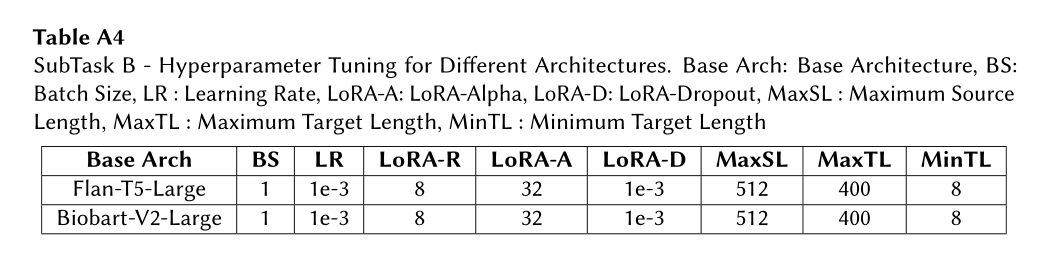

In [26]:
from peft import LoraConfig, get_peft_model

# Create an instance of 'LoraConfig' with specific configuration options.
    # 'r=8' sets the number of expert heads in the LoRA module to 8.
    # 'lora_alpha=32' sets the alpha value for LoRA gating mechanism to 32.
    # 'target_modules' specifies the modules where the LoRA module will be inserted, i.e., "q_proj" and "v_proj".
    # 'lora_dropout=0.05' sets the dropout rate for the LoRA module to 0.05.
    # 'bias="none"' specifies that no bias will be used in the LoRA module.
    # 'task_type="CAUSAL_LM"' sets the task type as "CAUSAL_LM" (Causal Language Modeling).
config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=1e-3,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

# Get the model with the LoRA module using the 'get_peft_model' function.
# This function inserts the LoRA module into the specified 'model' according to the provided 'config'.
summarization_model = get_peft_model(summarization_model, config)


In [27]:
from torch.nn.utils import clip_grad_norm_
# Define optimizer and loss function for summarization model
optimizer = transformers.AdamW(summarization_model.parameters(), lr=learning_rate, weight_decay=0.01)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Start the Training

In [28]:
def validate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for batch in data_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            labels_attention_mask = batch[3].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                            labels=labels, decoder_attention_mask=labels_attention_mask)
            loss = outputs.loss
            total_loss += loss.item()
            num_batches += 1

    average_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return average_loss


In [29]:
from tqdm import tqdm

# Set the number of epochs for training
num_epochs = 10


# Define a directory to save the checkpoints
checkpoint_dir = os.path.join(DATASET_BASE_DIR,"checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize variables to track best validation loss and corresponding checkpoint
best_validation_loss = float('inf')
best_checkpoint_path = None

# Fine-tune the summarization model on the GPU and use tqdm to display a progress bar
for epoch in range(num_epochs):
    running_loss = 0.0
    # Iterate over the batches in the data loader
    for i, batch in enumerate(tqdm(data_loader_train)):
        # Move batch data to the appropriate device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        labels_attention_mask = batch[3].to(device)

        # Forward pass: compute model outputs and loss
        outputs = summarization_model(input_ids=input_ids, attention_mask=attention_mask,
                                      labels=labels, decoder_attention_mask=labels_attention_mask)
        loss = outputs.loss

        # Backward pass: compute gradients
        loss.backward()

        # Apply gradient clipping to prevent exploding gradients
        clip_grad_norm_(summarization_model.parameters(), max_norm=1.0)

        # Update model parameters using the optimizer
        optimizer.step()

        # Clear gradients for the next iteration
        optimizer.zero_grad()

        # Accumulate the loss for monitoring
        running_loss += loss.item()

        # Print the average loss every 100 batches
        if i % 100 == 99:
            tqdm.write(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    # Save the model checkpoint after each epoch
    checkpoint_filename = f"checkpoint_epoch_{epoch + 1}.pt"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
    torch.save(summarization_model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved at: {checkpoint_path}")

    # Validation phase
    validation_loss = validate_model(summarization_model, data_loader_val)

    # Check if the current model is the best so far
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        best_checkpoint_path = checkpoint_path

  8%|▊         | 100/1201 [01:35<16:22,  1.12it/s]

Epoch 1, Batch 100, Loss: 0.1472


 17%|█▋        | 200/1201 [03:02<14:20,  1.16it/s]

Epoch 1, Batch 200, Loss: 0.1608


 25%|██▍       | 300/1201 [04:28<12:46,  1.18it/s]

Epoch 1, Batch 300, Loss: 0.1135


 33%|███▎      | 400/1201 [05:52<11:21,  1.18it/s]

Epoch 1, Batch 400, Loss: 0.1235


 42%|████▏     | 500/1201 [07:17<09:55,  1.18it/s]

Epoch 1, Batch 500, Loss: 0.1422


 50%|████▉     | 600/1201 [08:42<08:31,  1.18it/s]

Epoch 1, Batch 600, Loss: 0.1691


 58%|█████▊    | 700/1201 [10:07<07:05,  1.18it/s]

Epoch 1, Batch 700, Loss: 0.1502


 67%|██████▋   | 800/1201 [11:32<05:40,  1.18it/s]

Epoch 1, Batch 800, Loss: 0.1180


 75%|███████▍  | 900/1201 [12:57<04:16,  1.17it/s]

Epoch 1, Batch 900, Loss: 0.0923


 83%|████████▎ | 1000/1201 [14:22<02:50,  1.18it/s]

Epoch 1, Batch 1000, Loss: 0.1005


 92%|█████████▏| 1100/1201 [15:47<01:26,  1.17it/s]

Epoch 1, Batch 1100, Loss: 0.1223


100%|█████████▉| 1200/1201 [17:11<00:00,  1.18it/s]

Epoch 1, Batch 1200, Loss: 0.1131


100%|██████████| 1201/1201 [17:12<00:00,  1.16it/s]


Checkpoint saved at: /content/checkpoints/checkpoint_epoch_1.pt


  8%|▊         | 100/1201 [01:24<15:30,  1.18it/s]

Epoch 2, Batch 100, Loss: 0.1431


 17%|█▋        | 200/1201 [02:48<14:07,  1.18it/s]

Epoch 2, Batch 200, Loss: 0.1122


 25%|██▍       | 300/1201 [04:13<12:37,  1.19it/s]

Epoch 2, Batch 300, Loss: 0.1223


 33%|███▎      | 400/1201 [05:37<11:17,  1.18it/s]

Epoch 2, Batch 400, Loss: 0.0871


 42%|████▏     | 500/1201 [07:01<09:53,  1.18it/s]

Epoch 2, Batch 500, Loss: 0.1228


 50%|████▉     | 600/1201 [08:26<08:27,  1.18it/s]

Epoch 2, Batch 600, Loss: 0.1004


 58%|█████▊    | 700/1201 [09:50<07:02,  1.19it/s]

Epoch 2, Batch 700, Loss: 0.1073


 67%|██████▋   | 800/1201 [11:15<05:41,  1.18it/s]

Epoch 2, Batch 800, Loss: 0.1155


 75%|███████▍  | 900/1201 [12:39<04:13,  1.19it/s]

Epoch 2, Batch 900, Loss: 0.1224


 83%|████████▎ | 1000/1201 [14:04<02:49,  1.18it/s]

Epoch 2, Batch 1000, Loss: 0.1053


 92%|█████████▏| 1100/1201 [15:28<01:25,  1.18it/s]

Epoch 2, Batch 1100, Loss: 0.1222


100%|█████████▉| 1200/1201 [16:53<00:00,  1.18it/s]

Epoch 2, Batch 1200, Loss: 0.1173


100%|██████████| 1201/1201 [16:54<00:00,  1.18it/s]


Checkpoint saved at: /content/checkpoints/checkpoint_epoch_2.pt


  8%|▊         | 100/1201 [01:24<15:31,  1.18it/s]

Epoch 3, Batch 100, Loss: 0.0910


 17%|█▋        | 200/1201 [02:48<14:11,  1.18it/s]

Epoch 3, Batch 200, Loss: 0.1141


 25%|██▍       | 300/1201 [04:13<12:45,  1.18it/s]

Epoch 3, Batch 300, Loss: 0.0863


 33%|███▎      | 400/1201 [05:37<11:17,  1.18it/s]

Epoch 3, Batch 400, Loss: 0.1367


 42%|████▏     | 500/1201 [07:01<09:51,  1.18it/s]

Epoch 3, Batch 500, Loss: 0.0999


 50%|████▉     | 600/1201 [08:26<08:26,  1.19it/s]

Epoch 3, Batch 600, Loss: 0.1323


 58%|█████▊    | 700/1201 [09:50<07:04,  1.18it/s]

Epoch 3, Batch 700, Loss: 0.0972


 67%|██████▋   | 800/1201 [11:15<05:38,  1.18it/s]

Epoch 3, Batch 800, Loss: 0.1069


 75%|███████▍  | 900/1201 [12:39<04:16,  1.17it/s]

Epoch 3, Batch 900, Loss: 0.1037


 83%|████████▎ | 1000/1201 [14:04<02:49,  1.19it/s]

Epoch 3, Batch 1000, Loss: 0.1047


 92%|█████████▏| 1100/1201 [15:28<01:26,  1.17it/s]

Epoch 3, Batch 1100, Loss: 0.0872


100%|█████████▉| 1200/1201 [16:53<00:00,  1.18it/s]

Epoch 3, Batch 1200, Loss: 0.1125


100%|██████████| 1201/1201 [16:54<00:00,  1.18it/s]


Checkpoint saved at: /content/checkpoints/checkpoint_epoch_3.pt


# Save the tuned Model

In [30]:
# Load the best checkpoint after training
if best_checkpoint_path:
    summarization_model.load_state_dict(torch.load(best_checkpoint_path))
    print(f"Best checkpoint loaded from: {best_checkpoint_path}")
else:
    print("No best checkpoint found.")

Best checkpoint loaded from: /content/checkpoints/checkpoint_epoch_3.pt


# Evaluate

In [34]:
chat = dataset_val[0]["dialogue"]
summ = dataset_val[0]["summary"]

In [37]:
chat

"GENHX</s>Doctor: Good afternoon, sir. Did you just have a birthday? I don't have my chart with me right now, the nurse is bringing it. Patient: Good afternoon, sir. Yes, I just turned fifty five. Doctor: You identify as African American, correct? Patient: Yes, that's right. Doctor: When was your last visit, sir? Patient: Um, it was on July twenty ninth two thousand eight. Doctor: Yes, I see. Did we go over your M R I results? Patient: No, I was having those new seizures, remember?Doctor: Yes, I do. Well, the M R I demonstrated right contrast temporal mass. Patient: What exactly does that mean, doctor? Doctor: Well, given this mass, and your new seizures, I am concerned that this could be a high grade glioma, we'll need to do more tests."

In [48]:
# Generate summary of the dialog "chat" using the fine-tuned summarization model
summarization_model.eval()
input_ids = tokenizer.encode(chat, return_tensors='pt', padding=True).to(device)
outputs = summarization_model.generate(input_ids=input_ids, max_length=128, early_stopping=True,do_sample=True).to(device)
generated_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
generated_summary

'The patient is a 55-year-old African-American male who presents to me on 07/29/2008.  He states that he does not have a history of seizures, but that his right temporal mass has been noted.  Given the history of new seizures and the mass, he is concerned that this could be a high-grade glioma.'

In [49]:
print("Summary:")
print(summ)
print("="*100)
print("Generated summary")
print(generated_summary)

Summary:
The patient is a 55-year-old African-American male that was last seen in clinic on 07/29/2008 with diagnosis of new onset seizures and an MRI scan, which demonstrated right contrast-enhancing temporal mass.  Given the characteristics of this mass and his new onset seizures, it is significantly concerning for a high-grade glioma.
Generated summary
The patient is a 55-year-old African-American male who presents to me on 07/29/2008.  He states that he does not have a history of seizures, but that his right temporal mass has been noted.  Given the history of new seizures and the mass, he is concerned that this could be a high-grade glioma.


----